## COMP 8210 :BIG DATA TECHNOLGIES

## Data Cleaning 

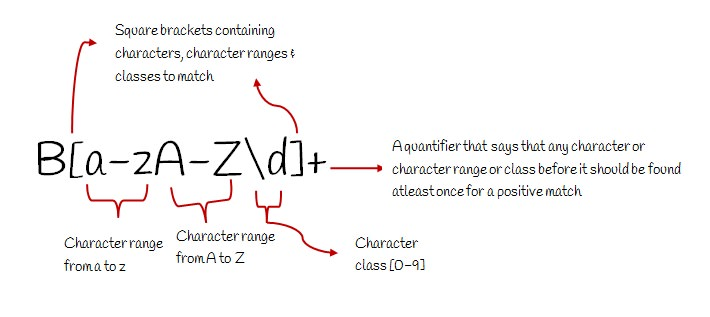

we are using regex for data cleaning 
Refernce : https://regex101.com/

In [1]:
import re
import json
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91999\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
filename =  open('C://Users//91999//Desktop//10000 tweets.json', encoding='utf-8').read()
remove_comments = re.sub(r"\/\*.+\*\/",',',filename)
y = re.compile(r"^[^,].+\(.+\),$",flags = re.MULTILINE)
x = "["+remove_comments.strip(',').strip().strip(',')+"]"

In [3]:
clean_1 = re.sub(r"\"_id\"(.*)+\,","",x)

In [4]:
clean_2 = re.sub(r"^[^,].+NumberLong\(.*,$", ""  ,clean_1, flags=re.MULTILINE)

In [5]:
with open("tweets.json", "w", encoding = 'utf-8') as text_file:
    text_file.write(clean_2)

In [6]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

In [7]:
connection = MongoClient("mongodb://localhost:27017")
db = connection.local

## Extraction 

## schema based features

In [8]:
time_zone = list()
DisplayName = list()
tweets = list()
languages = list()

all_tweets =  db.tweets.find({},{"actor":1,"_id":0})
tweet_text = db.tweets.find({},{"text":1,"_id":0})

for tweet in all_tweets:
    time_zone.append(tweet['actor']['twitterTimeZone'])
    
for d in db.tweets.find({},{"actor":1,"_id":0}):
     DisplayName.append(d['actor']['displayName'])
        
for text in tweet_text:
    tweets.append(text['text'])
    
for lang in db.tweets.find({},{"twitter_lang":1,"_id":0}):
    languages.append(lang['twitter_lang'])

In [9]:
schema = pd.DataFrame({"Display_Name": DisplayName,"timezone":time_zone,"tweet": tweets,"language": languages})
schema.head()

,Display_Name,timezone,tweet,language
0,losebabyweight,Sydney,CONGRATULATIONS Suzie Walker on both your beau...,en
1,Wantirna Weather,Melbourne,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",en
2,SAS Australia and NZ,Sydney,Join us @ the Hilton Sydney 2 learn how 2 make...,en
3,Letti.,Brisbane,Say Hello to this Gorgeous Gingham Dress! \n\n...,en
4,Intelledox,Canberra,Register for #Convergence2016 to hear@ChelleMe...,en


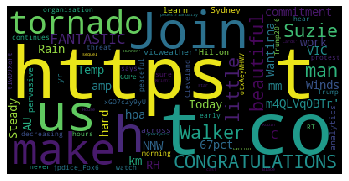

In [53]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = schema['tweet'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Lexical Based Features

In [10]:
lexical = pd.DataFrame(columns = ['text','clean_text','keywords','Named Entities'])

In [11]:
txt = []
ids = []
for t in db.tweets.find({},{"text":1,"_id":0,}):
    lexical = lexical.append(t,ignore_index = True)

In [12]:
corpus = []
for i in range(0, len(lexical)):
    review = lexical['text'][i]
    review = re.sub(r'\S+//\S+',' ',review)
    lexical['clean_text'].iloc[i] = review
    
    
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if  word not in  stop_words]
    list1 = nltk.pos_tag(review)
    lexical['keywords'].iloc[i] = list1

In [13]:
import spacy 
nlp = spacy.load("C://Users//91999//AppData//Local//Programs//Python//Python37//Lib//site-packages//en_core_web_sm//en_core_web_sm-3.1.0")
named_entities = []
for text in lexical['clean_text']:
    doc = nlp(text).ents
    temp = [(i.text,i.label_) for i in doc]
    named_entities.append(temp)
    
lexical['Named Entities'] = named_entities

In [14]:
lexical.head()

,text,clean_text,keywords,Named Entities
0,CONGRATULATIONS Suzie Walker on both your beau...,CONGRATULATIONS Suzie Walker on both your beau...,"[(congratul, NN), (suzi, NN), (walker, NN), (b...","[(CONGRATULATIONS, ORG), (Suzie Walker, PERSON..."
1,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","[(wantirna,, NN), (vic,, NN), (AU, NNP), (11:0...","[(Wantirna, ORG), (VIC, ORG), (AU, GPE), (19.8..."
2,Join us @ the Hilton Sydney 2 learn how 2 make...,Join us @ the Hilton Sydney 2 learn how 2 make...,"[(join, VB), (us, PRP), (@, JJ), (hilton, NN),...","[(2, CARDINAL)]"
3,Say Hello to this Gorgeous Gingham Dress! \n\n...,Say Hello to this Gorgeous Gingham Dress! \n\n...,"[(say, VB), (hello, NN), (gorgeou, NN), (gingh...","[(Party, ORG), (50, MONEY), (Only $40, MONEY)]"
4,Register for #Convergence2016 to hear@ChelleMe...,Register for #Convergence2016 to hear@ChelleMe...,"[(regist, NN), (#convergence2016, NNP), (hear@...",[]


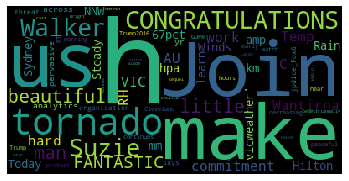

In [54]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = lexical['clean_text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Time based features

In [15]:
timestamp = []
for tweet in db. tweets.find({},{"postedTime":1,"_id":0}):
    timestamp.append(tweet["postedTime"])

In [16]:
time_Zone = []
for e in db. tweets.find({},{"actor.twitterTimeZone":1,"_id":0}):
    time_Zone.append(e['actor']['twitterTimeZone'])

In [17]:
time_based = pd.DataFrame({"Timestamp":timestamp,"TimeZone":time_zone})
time_based.head()

,Timestamp,TimeZone
0,2016-04-01T00:00:01.000Z,Sydney
1,2016-04-01T00:00:01.000Z,Melbourne
2,2016-04-01T00:00:01.000Z,Sydney
3,2016-04-01T00:00:03.000Z,Brisbane
4,2016-04-01T00:00:00.000Z,Canberra


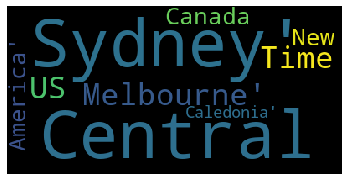

In [55]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = time_based['TimeZone'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## location based features 

In [18]:
loc = [""]*10000
for i,tweet in enumerate(db.tweets.find({},{"actor.location.displayName":1,"_id":0})):
    if "actor" in tweet:
        actor = tweet['actor']
        if "location" in actor:
            location = actor['location']
            if 'displayName' in location:
                disp = location['displayName']
                loc[i]=disp

In [19]:
geo = [""]*10000
for i,tweet in enumerate(db.tweets.find({},{"gnip.profileLocations.geo.coordinates":1,"_id":0})):
    if "gnip" in tweet:
        gnip = tweet['gnip']
        if "profileLocations" in gnip:
            prof = gnip['profileLocations']
            if len(prof)>0:
                prof=prof[0]
                if 'geo' in prof:
                    geo1 = prof['geo']
                    if 'coordinates' in geo1:
                        geo[i]=geo1['coordinates']
                        

In [20]:
location_based = pd.DataFrame({"location":loc,"Geo":geo})
location_based.head()

,location,Geo
0,Australia,"[135.0, -25.0]"
1,"Victoria, Australia","[145.0, -37.0]"
2,Australia and New Zealand,"[174.0, -42.0]"
3,Australia,"[135.0, -25.0]"
4,"Canberra, Australia","[149.12807, -35.28346]"


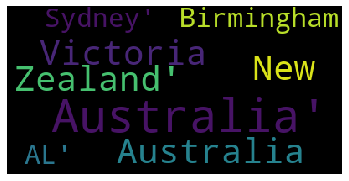

In [57]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = location_based['location'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Lexical-based Semantics

## synonymns

In [21]:
def enrich_syn(word):
    syn = list()
    
    for synonyms in wordnet.synsets(word):
        lem = synonyms.lemmas()

        for lemma in lem:
            syn.append(lemma.name())
           
    return list(set(syn))

## stems 

In [22]:
def enrich_stem(word):
    return(ps.stem(word))

## Hypernymns

In [23]:
from nltk.corpus import wordnet

In [24]:
def enrich_hypernym(word):
    synArray = wordnet.synsets(word)
    if len(synArray)>0:
        woi = synArray[0]
        words = []
        for i in woi.hypernyms():
            lem = i.lemmas()
            for lemma in lem:
                words.append(lemma.name())
        return words
    return []

## Hyponyms

In [25]:
def enrich_hyponyms(word):
    synArray = wordnet.synsets(word)
    if len(synArray)>0:
        woi = synArray[0]
        words = []
        for i in woi.hyponyms():
            lem = i.lemmas()
            for lemma in lem:
                words.append(lemma.name())
        return words
    return []

In [26]:
syns = []
stems = []
hyper = []
hypo = []
for i in range(len(lexical)):
# for i in range(1):
    syn1 = []
    stem1=[]
    hyper1=[]
    hypo1=[]
    for word in lexical['clean_text'][i].split(" "):
#         print(word)
        syn1+=enrich_syn(word)
        stem1.append(enrich_stem(word))
        hyper1+=enrich_hypernym(word)
        hypo1+=enrich_hyponyms(word)
    syns.append(syn1)
    stems.append(stem1)
    hyper.append(hyper1)
    hypo.append(hypo1)

In [27]:
lex = [syns,stems,hyper,hypo]
lexical_enriched = pd.DataFrame(lex).transpose()
lexical_enriched.columns=["Synonyms","Stems","Hypernyms","Hypo"]

In [28]:
lexical_enriched.head()

,Synonyms,Stems,Hypernyms,Hypo
0,"[kudos, congratulation, praise, congratulation...","[congratul, suzi, walker, on, both, your, beau...","[approval, commendation, small_indefinite_quan...","[compliment, encomium, eulogy, panegyric, paea..."
1,"[Au, Astronomical_Unit, gold, AU, atomic_numbe...","[wantirna,, vic,, AU, 11:00, AM, temp, 19.8°c,...","[noble_metal, metallic_element, metal, worker,...","[24-karat_gold, pure_gold, gold_dust, green_go..."
2,"[unite, junction, link_up, fall_in, connect, c...","[join, us, @, the, hilton, sydney, 2, learn, h...","[connection, connexion, link, digit, figure, d...","[esophagogastric_junction, oesophagogastric_ju..."
3,"[say, aver, sound_out, state, enjoin, articula...","[say, hello, to, thi, gorgeou, gingham, dress!...","[opportunity, chance, greeting, salutation, fa...","[date, day_of_the_month, date, eve, morrow, to..."
4,"[cash_register, cross-file, show, register, re...","[regist, for, #convergence2016, to, hear@chell...","[written_record, written_account, conversation...","[cadaster, cadastre, check_register, rent-roll..."


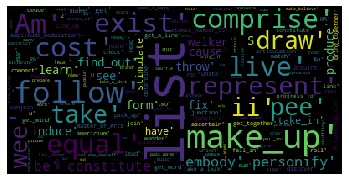

In [58]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = lexical_enriched['Synonyms'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

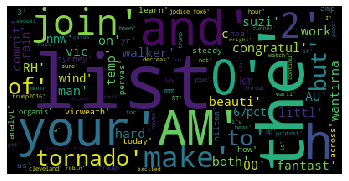

In [59]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = lexical_enriched['Stems'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

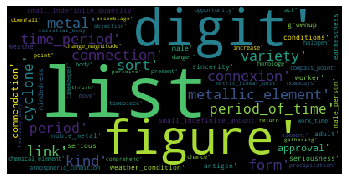

In [61]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = lexical_enriched['Hypernyms'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

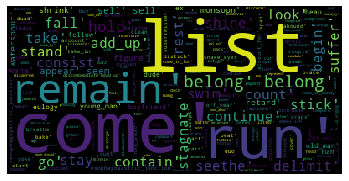

In [62]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = lexical_enriched['Hypo'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

https://docs.microsoft.com/en-us/python/api/overview/azure/ai-textanalytics-readme?view=azure-python#recognize-linked-entities

## NL-based Semantics

In [29]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.textanalytics import TextAnalyticsClient

credential = AzureKeyCredential("25de789ca0534eb581d58a88350ef3e1")
endpoint="https://<region>.api.cognitive.microsoft.com/"

text_analytics_client = TextAnalyticsClient('https://tweetanalyse.cognitiveservices.azure.com/', credential)

In [30]:
def related_Entities(documents):
    response = text_analytics_client.recognize_linked_entities(documents, language="en")
    result = [doc for doc in response if not doc.is_error]
    res1 = [] 
    
    for doc in result:
        for entity in doc.entities:
            name = entity.name
            url = entity.url
            data_Source = entity.data_source
                
            for match in entity.matches:
                match_text = match.text
                confidence_score  = match.confidence_score
                offset = match.offset
                res1.append([name,url,data_Source,match_text,confidence_score,offset])
    return res1

In [31]:
documents3 = list(lexical['clean_text'])
sentimentDF7 = pd.DataFrame()
for i in range(0,len(documents3[:5]), 5):
    doc = documents3[i:i+5]
    res2 = related_Entities(doc)
    
dataframe_1= pd.DataFrame(res2)
dataframe_1.columns=["Name","Url","Data_Source","Match_text","Confidence_score","Offset"]

In [32]:
dataframe_1.head()

,Name,Url,Data_Source,Match_text,Confidence_score,Offset
0,Congratulations (Cliff Richard song),https://en.wikipedia.org/wiki/Congratulations_...,Wikipedia,CONGRATULATIONS,0.02,0
1,"Wantirna, Victoria","https://en.wikipedia.org/wiki/Wantirna,_Victoria",Wikipedia,Wantirna,0.10,0
2,Victoria (Australia),https://en.wikipedia.org/wiki/Victoria_(Austra...,Wikipedia,"VIC, AU",0.74,10
3,Amplitude modulation,https://en.wikipedia.org/wiki/Amplitude_modula...,Wikipedia,AM,0.01,24
4,Croatia,https://en.wikipedia.org/wiki/Croatia,Wikipedia,RH,0.01,40


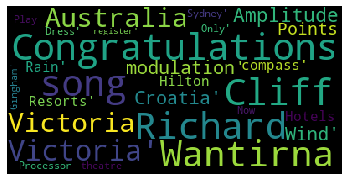

In [63]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = dataframe_1['Name'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

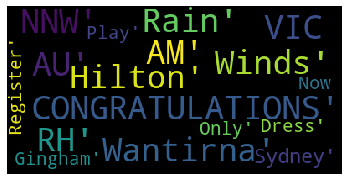

In [64]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
text = dataframe_1['Match_text'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##  Classification: Sentiment Analysis and Visualization 

In [33]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

def authenticate_client():
    ta_credential = AzureKeyCredential('25de789ca0534eb581d58a88350ef3e1')
    text_analytics_client = TextAnalyticsClient(
            endpoint= 'https://tweetanalyse.cognitiveservices.azure.com/', 
            credential=ta_credential)
    return text_analytics_client
""
client = authenticate_client()

In [34]:
def sentiment_analysis(documents):
    response = client.analyze_sentiment(documents, language="en")
    result = [doc for doc in response if not doc.is_error]
    res = []   
    for doc in result:
        positive = doc.confidence_scores.positive,
        neutral = doc.confidence_scores.neutral,
        negative = doc.confidence_scores.negative
        res.append([positive,neutral,negative])
        
    return res       

In [35]:
sentimentDF5 = pd.DataFrame()
for i in range(0,len(documents3[:1]), 10):
    doc = documents3[i:i+ 10]
    res = sentiment_analysis(doc)
    for j in range(len(res)):
        sentimentDF5 = sentimentDF5.append({"documents": doc[j], "positive": res[j][0][0],"neutral": res[j][1][0], "negative": res[j][2] },ignore_index=True )

In [36]:
sentimentDF5.head()

,documents,negative,neutral,positive
0,CONGRATULATIONS Suzie Walker on both your beau...,0.00,0.03,0.97
1,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",0.00,0.99,0.01
2,Join us @ the Hilton Sydney 2 learn how 2 make...,0.11,0.85,0.04
3,Say Hello to this Gorgeous Gingham Dress! \n\n...,0.00,0.01,0.99
4,Register for #Convergence2016 to hear@ChelleMe...,0.01,0.95,0.04


## clustering 

In [37]:
final = schema.join(lexical)
final1 = time_based.join(location_based)
final2 = lexical_enriched.join(dataframe_1)
final3 = sentimentDF5
final4 = final.join(final1)
final5 = final2.join(final3)
clusteringdata= final4.join(final5)
clusteringdata

,Display_Name,timezone,tweet,language,text,clean_text,keywords,Named Entities,Timestamp,TimeZone,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
0,losebabyweight,Sydney,CONGRATULATIONS Suzie Walker on both your beau...,en,CONGRATULATIONS Suzie Walker on both your beau...,CONGRATULATIONS Suzie Walker on both your beau...,"[(congratul, NN), (suzi, NN), (walker, NN), (b...","[(CONGRATULATIONS, ORG), (Suzie Walker, PERSON...",2016-04-01T00:00:01.000Z,Sydney,...,Congratulations (Cliff Richard song),https://en.wikipedia.org/wiki/Congratulations_...,Wikipedia,CONGRATULATIONS,0.02,0.0,CONGRATULATIONS Suzie Walker on both your beau...,0.00,0.03,0.97
1,Wantirna Weather,Melbourne,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",en,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","[(wantirna,, NN), (vic,, NN), (AU, NNP), (11:0...","[(Wantirna, ORG), (VIC, ORG), (AU, GPE), (19.8...",2016-04-01T00:00:01.000Z,Melbourne,...,"Wantirna, Victoria","https://en.wikipedia.org/wiki/Wantirna,_Victoria",Wikipedia,Wantirna,0.10,0.0,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",0.00,0.99,0.01
2,SAS Australia and NZ,Sydney,Join us @ the Hilton Sydney 2 learn how 2 make...,en,Join us @ the Hilton Sydney 2 learn how 2 make...,Join us @ the Hilton Sydney 2 learn how 2 make...,"[(join, VB), (us, PRP), (@, JJ), (hilton, NN),...","[(2, CARDINAL)]",2016-04-01T00:00:01.000Z,Sydney,...,Victoria (Australia),https://en.wikipedia.org/wiki/Victoria_(Austra...,Wikipedia,"VIC, AU",0.74,10.0,Join us @ the Hilton Sydney 2 learn how 2 make...,0.11,0.85,0.04
3,Letti.,Brisbane,Say Hello to this Gorgeous Gingham Dress! \n\n...,en,Say Hello to this Gorgeous Gingham Dress! \n\n...,Say Hello to this Gorgeous Gingham Dress! \n\n...,"[(say, VB), (hello, NN), (gorgeou, NN), (gingh...","[(Party, ORG), (50, MONEY), (Only $40, MONEY)]",2016-04-01T00:00:03.000Z,Brisbane,...,Amplitude modulation,https://en.wikipedia.org/wiki/Amplitude_modula...,Wikipedia,AM,0.01,24.0,Say Hello to this Gorgeous Gingham Dress! \n\n...,0.00,0.01,0.99
4,Intelledox,Canberra,Register for #Convergence2016 to hear@ChelleMe...,en,Register for #Convergence2016 to hear@ChelleMe...,Register for #Convergence2016 to hear@ChelleMe...,"[(regist, NN), (#convergence2016, NNP), (hear@...",[],2016-04-01T00:00:00.000Z,Canberra,...,Croatia,https://en.wikipedia.org/wiki/Croatia,Wikipedia,RH,0.01,40.0,Register for #Convergence2016 to hear@ChelleMe...,0.01,0.95,0.04
5,Kirra Sports Club,Brisbane,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",en,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","[(friday', RB), (3pm, CD), (free, JJ), (bbq,, ...","[(Friday, DATE), (3pm, TIME), (Free BBQ, PERSO...",2016-04-01T00:00:01.000Z,Brisbane,...,Wind,https://en.wikipedia.org/wiki/Wind,Wikipedia,Winds,0.08,50.0,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",0.01,0.52,0.47
6,James Bryron Love,Brisbane,Dormant by James Bryron Love https://t.co/JK8...,en,Dormant by James Bryron Love https://t.co/JK8...,Dormant by James Bryron Love #ASMSG #IAN1,"[(dormant, JJ), (jame, NN), (bryron, NN), (lov...","[(James Bryron, PERSON)]",2016-04-01T00:00:03.000Z,Brisbane,...,Points of the compass,https://en.wikipedia.org/wiki/Points_of_the_co...,Wikipedia,NNW,0.27,56.0,Dormant by James Bryron Love #ASMSG #IAN1,0.00,0.01,0.99
7,CTU Sydney,Sydney,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,en,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,"[(the, DT), (follow, JJ), (take, NN), (place, ...","[(THE FOLLOWING TAKES PLACE BETWEEN 11:00AM, O...",2016-04-01T00:00:04.000Z,Sydney,...,Rain,https://en.wikipedia.org/wiki/Rain,Wikipedia,Rain,0.14,72.0,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,0.00,1.00,0.00
8,What's On Aussie,None,So much to see and do when you Visit Central A...,en,So much to see and do when you Visit Central A...,So m

In [38]:
clusteringdata.drop(['timezone','text','Geo'],axis=1)

,Display_Name,tweet,language,clean_text,keywords,Named Entities,Timestamp,TimeZone,location,Synonyms,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
0,losebabyweight,CONGRATULATIONS Suzie Walker on both your beau...,en,CONGRATULATIONS Suzie Walker on both your beau...,"[(congratul, NN), (suzi, NN), (walker, NN), (b...","[(CONGRATULATIONS, ORG), (Suzie Walker, PERSON...",2016-04-01T00:00:01.000Z,Sydney,Australia,"[kudos, congratulation, praise, congratulation...",...,Congratulations (Cliff Richard song),https://en.wikipedia.org/wiki/Congratulations_...,Wikipedia,CONGRATULATIONS,0.02,0.0,CONGRATULATIONS Suzie Walker on both your beau...,0.00,0.03,0.97
1,Wantirna Weather,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",en,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","[(wantirna,, NN), (vic,, NN), (AU, NNP), (11:0...","[(Wantirna, ORG), (VIC, ORG), (AU, GPE), (19.8...",2016-04-01T00:00:01.000Z,Melbourne,"Victoria, Australia","[Au, Astronomical_Unit, gold, AU, atomic_numbe...",...,"Wantirna, Victoria","https://en.wikipedia.org/wiki/Wantirna,_Victoria",Wikipedia,Wantirna,0.10,0.0,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",0.00,0.99,0.01
2,SAS Australia and NZ,Join us @ the Hilton Sydney 2 learn how 2 make...,en,Join us @ the Hilton Sydney 2 learn how 2 make...,"[(join, VB), (us, PRP), (@, JJ), (hilton, NN),...","[(2, CARDINAL)]",2016-04-01T00:00:01.000Z,Sydney,Australia and New Zealand,"[unite, junction, link_up, fall_in, connect, c...",...,Victoria (Australia),https://en.wikipedia.org/wiki/Victoria_(Austra...,Wikipedia,"VIC, AU",0.74,10.0,Join us @ the Hilton Sydney 2 learn how 2 make...,0.11,0.85,0.04
3,Letti.,Say Hello to this Gorgeous Gingham Dress! \n\n...,en,Say Hello to this Gorgeous Gingham Dress! \n\n...,"[(say, VB), (hello, NN), (gorgeou, NN), (gingh...","[(Party, ORG), (50, MONEY), (Only $40, MONEY)]",2016-04-01T00:00:03.000Z,Brisbane,Australia,"[say, aver, sound_out, state, enjoin, articula...",...,Amplitude modulation,https://en.wikipedia.org/wiki/Amplitude_modula...,Wikipedia,AM,0.01,24.0,Say Hello to this Gorgeous Gingham Dress! \n\n...,0.00,0.01,0.99
4,Intelledox,Register for #Convergence2016 to hear@ChelleMe...,en,Register for #Convergence2016 to hear@ChelleMe...,"[(regist, NN), (#convergence2016, NNP), (hear@...",[],2016-04-01T00:00:00.000Z,Canberra,"Canberra, Australia","[cash_register, cross-file, show, register, re...",...,Croatia,https://en.wikipedia.org/wiki/Croatia,Wikipedia,RH,0.01,40.0,Register for #Convergence2016 to hear@ChelleMe...,0.01,0.95,0.04
5,Kirra Sports Club,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",en,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","[(friday', RB), (3pm, CD), (free, JJ), (bbq,, ...","[(Friday, DATE), (3pm, TIME), (Free BBQ, PERSO...",2016-04-01T00:00:01.000Z,Brisbane,Australia,"[bikini, two-piece, Bikini, miss, lady_friend,...",...,Wind,https://en.wikipedia.org/wiki/Wind,Wikipedia,Winds,0.08,50.0,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",0.01,0.52,0.47
6,James Bryron Love,Dormant by James Bryron Love https://t.co/JK8...,en,Dormant by James Bryron Love #ASMSG #IAN1,"[(dormant, JJ), (jame, NN), (bryron, NN), (lov...","[(James Bryron, PERSON)]",2016-04-01T00:00:03.000Z,Brisbane,Brisbane,"[hibernating, abeyant, sleeping, torpid, dorma...",...,Points of the compass,https://en.wikipedia.org/wiki/Points_of_the_co...,Wikipedia,NNW,0.27,56.0,Dormant by James Bryron Love #ASMSG #IAN1,0.00,0.01,0.99
7,CTU Sydney,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,en,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,"[(the, DT), (follow, JJ), (take, NN), (place, ...","[(THE FOLLOWING TAKES PLACE BETWEEN 11:00AM, O...",2016-04-01T00:00:04.000Z,Sydney,Australia,"[conform_to, keep_abreast, watch_over, succeed...",...,Rain,https://en.wikipedia.org/wiki/Rain,Wikipedia,Rain,0.14,72.0,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,0.00,1.00,0.00
8,What's On Aussie,So much to see and do when you Visit Centra

In [39]:
clusteringdata.to_csv('clustering.csv',index=False)

In [40]:
clusteringdata

,Display_Name,timezone,tweet,language,text,clean_text,keywords,Named Entities,Timestamp,TimeZone,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
0,losebabyweight,Sydney,CONGRATULATIONS Suzie Walker on both your beau...,en,CONGRATULATIONS Suzie Walker on both your beau...,CONGRATULATIONS Suzie Walker on both your beau...,"[(congratul, NN), (suzi, NN), (walker, NN), (b...","[(CONGRATULATIONS, ORG), (Suzie Walker, PERSON...",2016-04-01T00:00:01.000Z,Sydney,...,Congratulations (Cliff Richard song),https://en.wikipedia.org/wiki/Congratulations_...,Wikipedia,CONGRATULATIONS,0.02,0.0,CONGRATULATIONS Suzie Walker on both your beau...,0.00,0.03,0.97
1,Wantirna Weather,Melbourne,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",en,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","[(wantirna,, NN), (vic,, NN), (AU, NNP), (11:0...","[(Wantirna, ORG), (VIC, ORG), (AU, GPE), (19.8...",2016-04-01T00:00:01.000Z,Melbourne,...,"Wantirna, Victoria","https://en.wikipedia.org/wiki/Wantirna,_Victoria",Wikipedia,Wantirna,0.10,0.0,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",0.00,0.99,0.01
2,SAS Australia and NZ,Sydney,Join us @ the Hilton Sydney 2 learn how 2 make...,en,Join us @ the Hilton Sydney 2 learn how 2 make...,Join us @ the Hilton Sydney 2 learn how 2 make...,"[(join, VB), (us, PRP), (@, JJ), (hilton, NN),...","[(2, CARDINAL)]",2016-04-01T00:00:01.000Z,Sydney,...,Victoria (Australia),https://en.wikipedia.org/wiki/Victoria_(Austra...,Wikipedia,"VIC, AU",0.74,10.0,Join us @ the Hilton Sydney 2 learn how 2 make...,0.11,0.85,0.04
3,Letti.,Brisbane,Say Hello to this Gorgeous Gingham Dress! \n\n...,en,Say Hello to this Gorgeous Gingham Dress! \n\n...,Say Hello to this Gorgeous Gingham Dress! \n\n...,"[(say, VB), (hello, NN), (gorgeou, NN), (gingh...","[(Party, ORG), (50, MONEY), (Only $40, MONEY)]",2016-04-01T00:00:03.000Z,Brisbane,...,Amplitude modulation,https://en.wikipedia.org/wiki/Amplitude_modula...,Wikipedia,AM,0.01,24.0,Say Hello to this Gorgeous Gingham Dress! \n\n...,0.00,0.01,0.99
4,Intelledox,Canberra,Register for #Convergence2016 to hear@ChelleMe...,en,Register for #Convergence2016 to hear@ChelleMe...,Register for #Convergence2016 to hear@ChelleMe...,"[(regist, NN), (#convergence2016, NNP), (hear@...",[],2016-04-01T00:00:00.000Z,Canberra,...,Croatia,https://en.wikipedia.org/wiki/Croatia,Wikipedia,RH,0.01,40.0,Register for #Convergence2016 to hear@ChelleMe...,0.01,0.95,0.04
5,Kirra Sports Club,Brisbane,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",en,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","[(friday', RB), (3pm, CD), (free, JJ), (bbq,, ...","[(Friday, DATE), (3pm, TIME), (Free BBQ, PERSO...",2016-04-01T00:00:01.000Z,Brisbane,...,Wind,https://en.wikipedia.org/wiki/Wind,Wikipedia,Winds,0.08,50.0,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",0.01,0.52,0.47
6,James Bryron Love,Brisbane,Dormant by James Bryron Love https://t.co/JK8...,en,Dormant by James Bryron Love https://t.co/JK8...,Dormant by James Bryron Love #ASMSG #IAN1,"[(dormant, JJ), (jame, NN), (bryron, NN), (lov...","[(James Bryron, PERSON)]",2016-04-01T00:00:03.000Z,Brisbane,...,Points of the compass,https://en.wikipedia.org/wiki/Points_of_the_co...,Wikipedia,NNW,0.27,56.0,Dormant by James Bryron Love #ASMSG #IAN1,0.00,0.01,0.99
7,CTU Sydney,Sydney,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,en,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,"[(the, DT), (follow, JJ), (take, NN), (place, ...","[(THE FOLLOWING TAKES PLACE BETWEEN 11:00AM, O...",2016-04-01T00:00:04.000Z,Sydney,...,Rain,https://en.wikipedia.org/wiki/Rain,Wikipedia,Rain,0.14,72.0,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,0.00,1.00,0.00
8,What's On Aussie,None,So much to see and do when you Visit Central A...,en,So much to see and do when you Visit Central A...,So m

In [41]:
import distance 
def jaccard(a, b):
    return distance.jaccard(a,b)

In [42]:
clusteringdata2 = [set(i.split(" ")) for i in clusteringdata.clean_text]

In [43]:
similarity = [ ]
rows = 1000
for i in range(rows):
    sim=[]
    for j in range(rows):
        sim.append(jaccard(clusteringdata2[i],clusteringdata2[j]))
    similarity.append(sim)

In [44]:
from scipy.cluster.vq import kmeans2

In [45]:
ans,label = kmeans2(similarity,3,minit='points')

In [46]:
w1 = clusteringdata.iloc[:rows,:][label==0]
w2 = clusteringdata.iloc[:rows,:][label==1]
w3 = clusteringdata.iloc[:rows,:][label==2]

In [47]:
w1.head()

,Display_Name,timezone,tweet,language,text,clean_text,keywords,Named Entities,Timestamp,TimeZone,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
0,losebabyweight,Sydney,CONGRATULATIONS Suzie Walker on both your beau...,en,CONGRATULATIONS Suzie Walker on both your beau...,CONGRATULATIONS Suzie Walker on both your beau...,"[(congratul, NN), (suzi, NN), (walker, NN), (b...","[(CONGRATULATIONS, ORG), (Suzie Walker, PERSON...",2016-04-01T00:00:01.000Z,Sydney,...,Congratulations (Cliff Richard song),https://en.wikipedia.org/wiki/Congratulations_...,Wikipedia,CONGRATULATIONS,0.02,0.0,CONGRATULATIONS Suzie Walker on both your beau...,0.00,0.03,0.97
2,SAS Australia and NZ,Sydney,Join us @ the Hilton Sydney 2 learn how 2 make...,en,Join us @ the Hilton Sydney 2 learn how 2 make...,Join us @ the Hilton Sydney 2 learn how 2 make...,"[(join, VB), (us, PRP), (@, JJ), (hilton, NN),...","[(2, CARDINAL)]",2016-04-01T00:00:01.000Z,Sydney,...,Victoria (Australia),https://en.wikipedia.org/wiki/Victoria_(Austra...,Wikipedia,"VIC, AU",0.74,10.0,Join us @ the Hilton Sydney 2 learn how 2 make...,0.11,0.85,0.04
3,Letti.,Brisbane,Say Hello to this Gorgeous Gingham Dress! \n\n...,en,Say Hello to this Gorgeous Gingham Dress! \n\n...,Say Hello to this Gorgeous Gingham Dress! \n\n...,"[(say, VB), (hello, NN), (gorgeou, NN), (gingh...","[(Party, ORG), (50, MONEY), (Only $40, MONEY)]",2016-04-01T00:00:03.000Z,Brisbane,...,Amplitude modulation,https://en.wikipedia.org/wiki/Amplitude_modula...,Wikipedia,AM,0.01,24.0,Say Hello to this Gorgeous Gingham Dress! \n\n...,0.00,0.01,0.99
4,Intelledox,Canberra,Register for #Convergence2016 to hear@ChelleMe...,en,Register for #Convergence2016 to hear@ChelleMe...,Register for #Convergence2016 to hear@ChelleMe...,"[(regist, NN), (#convergence2016, NNP), (hear@...",[],2016-04-01T00:00:00.000Z,Canberra,...,Croatia,https://en.wikipedia.org/wiki/Croatia,Wikipedia,RH,0.01,40.0,Register for #Convergence2016 to hear@ChelleMe...,0.01,0.95,0.04
5,Kirra Sports Club,Brisbane,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",en,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","Friday's from 3pm\nFree BBQ, Bikini Girls &amp...","[(friday', RB), (3pm, CD), (free, JJ), (bbq,, ...","[(Friday, DATE), (3pm, TIME), (Free BBQ, PERSO...",2016-04-01T00:00:01.000Z,Brisbane,...,Wind,https://en.wikipedia.org/wiki/Wind,Wikipedia,Winds,0.08,50.0,"Friday's from 3pm\nFree BBQ, Bikini Girls &amp...",0.01,0.52,0.47


In [48]:
w2.head()

,Display_Name,timezone,tweet,language,text,clean_text,keywords,Named Entities,Timestamp,TimeZone,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
1,Wantirna Weather,Melbourne,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",en,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...","[(wantirna,, NN), (vic,, NN), (AU, NNP), (11:0...","[(Wantirna, ORG), (VIC, ORG), (AU, GPE), (19.8...",2016-04-01T00:00:01.000Z,Melbourne,...,"Wantirna, Victoria","https://en.wikipedia.org/wiki/Wantirna,_Victoria",Wikipedia,Wantirna,0.10,0.0,"Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67p...",0.0,0.99,0.01
7,CTU Sydney,Sydney,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,en,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,"[(the, DT), (follow, JJ), (take, NN), (place, ...","[(THE FOLLOWING TAKES PLACE BETWEEN 11:00AM, O...",2016-04-01T00:00:04.000Z,Sydney,...,Rain,https://en.wikipedia.org/wiki/Rain,Wikipedia,Rain,0.14,72.0,THE FOLLOWING TAKES PLACE BETWEEN 11:00AM AND ...,0.0,1.00,0.00
19,Guy Pickett,Yakutsk,@moolaland once/if 1.2 breaks it's game on. $POH,en,@moolaland once/if 1.2 breaks it's game on. $POH,@moolaland once/if 1.2 breaks it's game on. $POH,"[(@moolaland, NN), (once/if, VBZ), (1.2, CD), ...","[(1.2, CARDINAL)]",2016-04-01T00:00:11.000Z,Yakutsk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Assis #Beta Lab,Brasilia,RT @ArtOutline: The Liberal party is a tool of...,en,RT @ArtOutline: The Liberal party is a tool of...,RT @ArtOutline: The Liberal party is a tool of...,"[(RT, NNP), (@artoutline:, VBZ), (the, DT), (l...","[(The Liberal party, ORG), (d'etre, PERSON)]",2016-04-01T00:00:13.000Z,Brasilia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Steph,Perth,this is so heartbreaking ... Please be okay......,en,this is so heartbreaking ... Please be okay......,this is so heartbreaking ... Please be okay......,"[(heartbreak, NN), (..., :), (pleas, RB), (oka...","[(💔, ORG)]",2016-04-01T00:00:15.000Z,Perth,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
w3.head()

,Display_Name,timezone,tweet,language,text,clean_text,keywords,Named Entities,Timestamp,TimeZone,...,Name,Url,Data_Source,Match_text,Confidence_score,Offset,documents,negative,neutral,positive
13,Luke Hemmings ♥,Sydney,RT @Tha5SOSFamily: 650 RTS!\n\nDO IT FOR 5SOS\...,en,RT @Tha5SOSFamily: 650 RTS!\n\nDO IT FOR 5SOS\...,RT @Tha5SOSFamily: 650 RTS!\n\nDO IT FOR 5SOS\...,"[(RT, NNP), (@tha5sosfamily:, VBD), (650, CD),...","[(RT @Tha5SOSFamily, ORG), (650, CARDINAL), (R...",2016-04-01T00:00:03.000Z,Sydney,...,Now Only,https://en.wikipedia.org/wiki/Now_Only,Wikipedia,Now Only,0.64,99.0,NaN,NaN,NaN,NaN
14,Jason English,None,RT @BreitbartTech: No Plans for Killer US Mili...,en,RT @BreitbartTech: No Plans for Killer US Mili...,RT @BreitbartTech: No Plans for Killer US Mili...,"[(RT, NNP), (@breitbarttech:, VBZ), (No, DT), ...","[(RT @BreitbartTech, PERSON), (Killer US Milit...",2016-04-01T00:00:03.000Z,None,...,Processor register,https://en.wikipedia.org/wiki/Processor_register,Wikipedia,Register,0.06,0.0,NaN,NaN,NaN,NaN
18,ESPN Australia & NZ,Sydney,"RT @ESPNGolf: From now until @TheMasters week,...",en,"RT @ESPNGolf: From now until @TheMasters week,...","RT @ESPNGolf: From now until @TheMasters week,...","[(RT, NNP), (@espngolf:, NN), (from, IN), (@th...","[(RT @ESPNGolf:, PERSON), (@TheMasters week, D...",2016-04-01T00:00:05.000Z,Sydney,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,✨HAPPY coz I'm free✨,Pacific Time (US & Canada),RT @SouthEastCASA: 20 Things to ask your kids ...,en,RT @SouthEastCASA: 20 Things to ask your kids ...,RT @SouthEastCASA: 20 Things to ask your kids ...,"[(RT, NNP), (@southeastcasa:, VBZ), (20, CD), ...","[(RT @SouthEastCASA, PERSON), (20, CARDINAL)]",2016-04-01T00:00:12.000Z,Pacific Time (US & Canada),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Adrian Washienko,None,RT @POWER1079: 2016 MLB predictions: Surprise ...,en,RT @POWER1079: 2016 MLB predictions: Surprise ...,RT @POWER1079: 2016 MLB predictions: Surprise ...,"[(RT, NNP), (@power1079:, NN), (2016, CD), (ml...","[(RT @POWER1079, PERSON), (2016, CARDINAL), (M...",2016-04-01T00:00:13.000Z,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
